# Advent of Code 2015


See [here](http://adventofcode.com/2015/).

## Preparation

Imports and utility functions that might or might not prove useful down the line.

In [1]:
# Python 3.x
import re
import numpy as np
import math
import urllib.request
import reprlib
import operator
import string
import hashlib

from collections import Counter, defaultdict, namedtuple, deque
from functools   import lru_cache, reduce
from itertools   import permutations, combinations, chain, cycle, product, islice, count, repeat, filterfalse
from heapq       import heappop, heappush
from enum        import Enum

# sometimes a graph helps
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)

def Input(day,strip=True):
    "Open this day's input file."
    
    filename = 'input/input{}.txt'.format(day)
    try:
        with open(filename, 'r') as f:
            text = f.read()
            if strip:
                text = text.strip()
        return text
    except FileNotFoundError:
        url = 'http://adventofcode.com/2017/day/{}/input'.format(day)
        print('input file not found. opening browser...')
        print('please save the file as "input<#day>.txt in your input folder.')
        import webbrowser
        webbrowser.open(url)

cat = ''.join
def first(iterable, default=None): return next(iter(iterable), default)
def nth(iterable, n, default=None): return next(islice(iterable, n, None), default)
def fs(*items): return frozenset(items)

def ilen(iterator): return sum(1 for _ in iterator)

def ints(text,typ=int):
    return list(map(typ,re.compile(r'[-+]?\d*[.]?\d+').findall(text)))

def shift(it, n):
    return it[n:] + it[:n]

def rot(mat, N=1, clockwise=True):
    '''rotate 2D matrix'''
    for _ in range(N):
        if clockwise:
            mat = list(zip(*mat[::-1]))
        else:
            mat = list(zip(*mat[::-1]))[::-1]
    return mat

def locate2D(m, val):
    '''locate value in 2D list'''
    for i, line in enumerate(m):
        j=-1
        try:
            j = line.index(val)
        except ValueError:
            continue
        break
    else:
        i = -1
    return (i,j)

def dist_L1(p1,p2=None):
    if p2 == None:
        p2 = repeat(0)
    return sum(abs(p2_i-p1_i) for p1_i, p2_i in zip(p1,p2))

def dist_L2(p1,p2=None):
    if p2 == None:
        p2 = repeat(0)
    return sum((p2_i-p1_i)*(p2_i-p1_i) for p1_i, p2_i in zip(p1,p2))**.5

def neighbors4(point): 
    "The four neighbors (without diagonals)."
    x, y = point
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1))

def neighbors8(point): 
    "The eight neighbors (with diagonals)."
    x, y = point 
    return ((x+1, y), (x-1, y), (x, y+1), (x, y-1),
            (x+1, y+1), (x-1, y-1), (x+1, y-1), (x-1, y+1))

from numbers import Number 
class Vector(object):
    def __init__(self,*args):
        if len(args) == 1:
            if isinstance(args,Number): self.vec = tuple(0 for _ in range(args))
            else: self.vec = tuple(*args)
        else: self.vec = tuple(args)
    def __mul__(self, other):
        if isinstance(other,Number): return Vector(other * x for x in self.vec)
        elif isinstance(other,Vector): return sum(x*y for x,y in zip(self.vec, other.vec))
        raise NotImplemented
    def __add__(self,other):
        return Vector(x+y for x,y in zip(self.vec, other.vec))
    def __sub__(self,other):
        return Vector(x-y for x,y in zip(self.vec, other.vec))
    def __iter__(self):
        return self.vec.__iter__()
    def __len__(self):
        return len(self.vec)
    def __getitem__(self, key):
        return self.vec[key]
    def __repr__(self):
        return 'Vector(' + str(self.vec)[1:-1] + ')'
    def __eq__(self, other):
        return self.vec == other.vec
    def __hash__(self):
        return hash(self.vec)

#display and debug functions
def h1(s):
    upr, brd, lwr = '▁', '█', '▔'
    return upr*(len(s)+4) + '\n'+brd+' ' + s + ' ' + brd +'\n' + lwr*(len(s)+4)

def h2(s, ch='-'):
    return s + '\n' + ch*len(s) + '\n'

h1 = lambda s: h2(s,'=')  #the other h1 is a bitch, apparently.

def print_result(day, part, text):
    print(h1('Day {} part {}: {}'.format(day, part, text)))

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    rep = reprlib.aRepr
    rep.maxother = 85
    def traced_f(*args):
        arg_strs = ', '.join(map(rep.repr, args))
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, arg_strs, result))
        return result
    return traced_f

## [Day 1: Not Quite Lisp](http://adventofcode.com/2015/day/1)

In [7]:
def get_floor(directions):
    UP, DOWN = '()'
    return directions.count(UP) - directions.count(DOWN)


directions = Input(1)
print_result(1,1,'destination floor is ' + str(get_floor(directions)))

Day 1 part 1: destination floor is 232



In [10]:
for step in count(1):
    floor = get_floor(directions[:step])
    if floor == -1:
        break
print_result(1,2,'basement reached after {} steps'.format(step))

Day 1 part 2: basement reached after 1783 steps



## [Day 2: I Was Told There Would Be No Math](http://adventofcode.com/2015/day/2)

Calculate how much wrapping paper is needed for a list of presents specified bei `width` x `height` x `length`.

Sample input looks like this:
```20x3x11
15x27x5
6x29x7
30x15x9
19x29x21
[...]```

Wrapping-paper-area is defined as surface area of the box (2*l*w + 2*w*h + 2*h*l) plus the area of the smallest side as slack.

In [15]:
def calc_area(l, w, h):
    a = l * w
    b = l * h
    c = w * h
    return 2 * (a + b + c) + min([a, b, c])


def parse_line(line):
    return [int(edge) for edge in line.strip().split('x')]


def solve_2_1(text):
    return sum(calc_area(*parse_line(line)) for line in text.splitlines())


assert calc_area(2, 3, 4) == 58
assert calc_area(1, 1, 10) == 43
assert calc_area(*parse_line('2x3x4')) == 58

rstr = '{} ft^2 of wrapping paper are needed.'
print_result(2, 1, rstr.format(solve_2_1(Input(2))))

Day 2 part 1: 1606483 ft^2 of wrapping paper are needed.



For part two we also need to calculate the length of a ribbon for a bow.

The ribbon required to wrap a present is the shortest distance around its sides, or the smallest perimeter of any one face. Each present also requires a bow made out of ribbon as well; the feet of ribbon required for the perfect bow is equal to the cubic feet of volume of the present. 

In [19]:
def calc_ribbon_length(l, w, h):
    a, b, c = sorted([l, w, h])
    return 2 * (a + b) + a * b * c


def solve_2_2(text):
    return sum(calc_ribbon_length(*parse_line(line)) for line in text.splitlines())


assert calc_ribbon_length(2, 3, 4) == 34
assert calc_ribbon_length(1, 1, 10) == 14

rstr2 = '{} ft of ribbon are needed.'
print_result(2, 2, rstr2.format(solve_2_2(Input(2))))

Day 2 part 2: 3842356 ft of ribbon are needed.



## [Day 3: Perfectly Spherical Houses in a Vacuum](http://adventofcode.com/2015/day/3)

Santa moves on a 2D grid, depositing presents on every field.
He follows the following instructions:
- `<` for left
- `>` for right
- `^` for up
- `v` for down

Sample input looks like this:

```>^^v^<>v<<<v<v^>>v^^^<v<>^^><^<<^vv>>>^<<^>> [...]```

How many houses are visited at least once?

In [25]:
dirs = {'^': +1j,
        'v': -1j,
        '<': -1,
        '>': +1}


def travel(directions):
    visited = [0]
    for d in directions:
        visited.append(visited[-1] + dirs[d])
    return visited


assert len(set(travel('>'))) == 2
assert len(set(travel('^>v<'))) == 4
assert len(set(travel('^v^v^v^v^v'))) == 2

visited = travel(Input(3))
print_result(3, 1, '{} houses visited'.format(len(set(visited))))

Day 3 part 1: 2592 houses visited



In part 2 Santa and [Robo-Santa](http://i.imgur.com/Le0U3YY.jpg) take turns following the directions.

In [27]:
def split_travel(directions):
    return travel(directions[::2]) + travel(directions[1::2])

assert len(set(split_travel('^v'))) == 3
assert len(set(split_travel('^>v<'))) == 3
assert len(set(split_travel('^v^v^v^v^v'))) == 11

visited = split_travel(Input(3))
print_result(3, 2, '{} houses visited'.format(len(set(visited))))

Day 3 part 2: 2360 houses visited



## [Day 4: The Ideal Stocking Stuffer](http://adventofcode.com/2015/day/4)

Find the lowest number for which the MD5 hash of a prefix (input) and that number starts with 5 zeros...

In [30]:
def gen_hash(key, num=5):
    for i in count():
        m = hashlib.md5()
        m.update(bytes(key + str(i), 'utf-8'))
        h = m.hexdigest()
        if h.startswith('0' * num):
            yield i


assert next(gen_hash('abcdef')) == 609043
assert next(gen_hash('pqrstuv')) == 1048970

print_result(4, 1, 'lowest number is ' + str(next(gen_hash(Input(4)))))

Day 4 part 1: lowest number is 254575



... and starting with 6 zeros for part 2.

In [32]:
print_result(4, 2, 'lowest number is ' + str(next(gen_hash(Input(4), num=6))))

Day 4 part 2: lowest number is 1038736



## [Day 5: Doesn't He Have Intern-Elves For This?](http://adventofcode.com/2015/day/5)

Find strings that match these criteria:

- contains at least three [aeiou]
- contains at least one repeated letter (e.g. 'xx')
- does not contain ab, cd, pq, or xy

Sample input looks like this:

```uxcplgxnkwbdwhrp
suerykeptdsutidb
dmrtgdkaimrrwmej
[...]```

In [36]:
def c1(text):
    return len([c for c in text if c in 'aeiou']) >= 3


def c2(text):
    matching_pairs = [a == b for a, b in zip(text[:-1], text[1:])]
    return any(matching_pairs)


def c3(text):
    return not any(cmb in text for cmb in ('ab', 'cd', 'pq', 'xy'))


def is_nice(text):
    return c1(text) and c2(text) and c3(text)

assert is_nice('ugknbfddgicrmopn')
assert is_nice('aaa')
assert not is_nice('jchzalrnumimnmhp')
assert not is_nice('haegwjzuvuyypxyu')
assert not is_nice('dvszwmarrgswjxmb')

nn_list = [is_nice(line) for line in Input(5).splitlines()]
print_result(5,1,'{} strings are nice'.format(nn_list.count(True)))

Day 5 part 1: 236 strings are nice



New criteria for part 2, because why not.

- contains a pair of any two letters that appears at least twice in the string without overlapping, like xyxy (xy) or aabcdefgaa (aa), but not like aaa (aa, but it overlaps).
- contains at least one letter which repeats with exactly one letter between them, like xyx, abcdefeghi (efe), or even aaa.


In [54]:
p4 = re.compile(r'(..).*\1')
def c4(text):
    return p4.search(text)

p5 = re.compile(r'(.).\1')
def c5(text):
    return p5.search(text)

def is_nice2(text):
    return c4(text) and c5(text)

assert is_nice2('qjhvhtzxzqqjkmpb')
assert is_nice2('xxyxx')
assert not is_nice2('uurcxstgmygtbstg')
assert not is_nice2('ieodomkazucvgmuy')

nn_list2 = [bool(is_nice2(line)) for line in Input(5).splitlines()]
print_result(5,2,'{} strings are nice'.format(nn_list2.count(True)))

Day 5 part 2: 51 strings are nice



## [Day 6: Probably a Fire Hazard](http://adventofcode.com/2015/day/6)

Switch lights on a 1000x1000 grid.

- lights start turned off
- you can turn them on/off or toggle them.
- `3,4 through 6,5` defines an inclusive rectangle that is to be switched

Sample input looks like

```toggle 461,550 through 564,900
turn off 370,39 through 425,839
turn off 464,858 through 833,915
turn off 812,389 through 865,874
turn on 599,989 through 806,993
[...]```

How many lights are turned on after we follow the instructions?

In [82]:
def grid_apply(grid, fun, rect):
    x0, y0, x1, y1 = rect
    for x, y in product(range(x0, x1 + 1), range(y0, y1 + 1)):
        grid[x][y] = fun(grid[x][y])
    return grid


def parse_line(line):
    pattern = re.compile(r'(.+) (\d+),(\d+) through (\d+),(\d+)')
    funs = {'toggle':   lambda x: not x,
            'turn on':  lambda x: True,
            'turn off': lambda x: False
           }
    cmd, *rect = pattern.match(line).groups()
    rect = tuple(int(x) for x in rect)
    return (funs[cmd], rect)


def run(grid, instructions):
    for line in instructions.splitlines():
        fun, rect = parse_line(line)
        grid = grid_apply(grid, fun, rect)
    return grid

N = 1000
grid = [[False for _ in range(N)] for _ in range(N)]
result = run(grid, Input(6))
print_result(6,1,'{} lights are turned on'.format(sum(result,[]).count(True)))

Day 6 part 1: 543903 lights are turned on



Let's see if that looks fancy in any way...

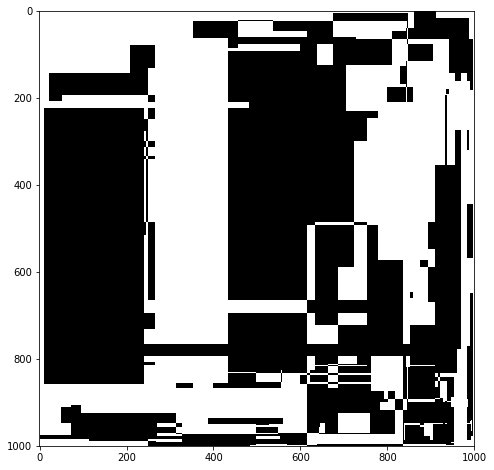

In [83]:
plt.imshow(result, cmap='Greys',  interpolation='nearest')
plt.show()

It does not.

On to part two... new rules.
- The light grid you bought actually has individual brightness controls; each light can have a brightness of zero or more. The lights all start at zero.
- The phrase turn on actually means that you should increase the brightness of those lights by 1. 
- The phrase turn off actually means that you should decrease the brightness of those lights by 1, to a minimum of zero.
- The phrase toggle actually means that you should increase the brightness of those lights by 2.

In [77]:
def parse_line(line):
    pattern = re.compile(r'(.+) (\d+),(\d+) through (\d+),(\d+)')
    funs = {'toggle': lambda x: x + 2,
            'turn on': lambda x: x + 1,
            'turn off': lambda x: max(0, x - 1)
            }
    cmd, *rect = pattern.match(line).groups()
    rect = tuple(int(x) for x in rect)
    return (funs[cmd], rect)


def run(grid, instructions):
    for line in instructions.splitlines():
        fun, rect = parse_line(line)
        grid = grid_apply(grid, fun, rect)
    return grid


N = 1000
grid = [[0 for _ in range(N)] for _ in range(N)]
result = run(grid, Input(6))
print_result(6, 2, 'brightness of {} has been achieved'.format(
    sum(sum(result, []))))

Day 6 part 2: brightness of 14687245 has been achieved



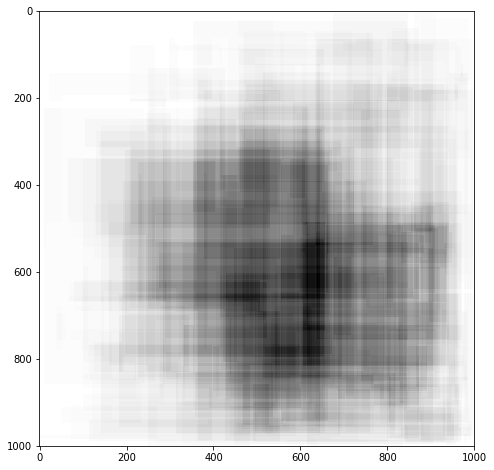

In [80]:
plt.imshow(result, cmap='Greys',  interpolation='nearest')
plt.show()

Still doesnt look like much.

## [Day 7: Some Assembly Required](http://adventofcode.com/2015/day/7)

Run some logic code on registers.

A line of code can only be evaluated once all registers it depends on have values.

Sample input looks like this:
    
```af AND ah -> ai
NOT lk -> ll
hz RSHIFT 1 -> is
NOT go -> gp
du OR dt -> dv
x RSHIFT 5 -> aa
at OR az -> ba
eo LSHIFT 15 -> es
ci OR ct -> cu
14146 -> b
[...]```

This could be a tough problem if we had to actually run the instructions in the appropriate order.

Just trying to run them and postponing them if the register-lookup fails works too, and is way easier.

In [117]:
ops = {'AND': lambda x, y: x & y,
       'OR': lambda x, y: x | y,
       'LSHIFT': lambda x, y: x << y,
       'RSHIFT': lambda x, y: x >> y,
       'NOT': lambda x: ~x + (1 << 16),
       'ASGN': lambda x: x,
       }

assert ops['AND'](123, 456) == 72
assert ops['OR'](123, 456) == 507
assert ops['LSHIFT'](123, 2) == 492
assert ops['RSHIFT'](456, 2) == 114
assert ops['NOT'](123) == 65412
assert ops['NOT'](456) == 65079


def regeval(reg, s):
    if not s.isalpha():
        s = int(s)
    else:
        s = reg[s]
    return s


def parse_input(text):
    asign_pattern = re.compile(r'^(\S+) -> (\S+)$', re.MULTILINE)
    for source, dest in asign_pattern.findall(text):
        yield (dest, 'ASGN', source)
    unary_pattern = re.compile(r'^([A-Z]+) (\S+) -> (\S+)$', re.MULTILINE)
    for op, x, dest in unary_pattern.findall(text):
        yield (dest, op, x)
    binary_pattern = re.compile(
        r'^(\S+) ([A-Z]+) (\S+) -> (\S+)$', re.MULTILINE)
    for x, op, y, dest in binary_pattern.findall(text):
        yield (dest, op, x, y)


def run(text, register=None):
    instructions = deque(parse_input(text))
    reg = dict()
    if register is not None:
        reg.update(register)
    while len(instructions) > 0:
        instr = instructions.popleft()
        dest, op, *args = instr
        try:
            if dest not in reg:
                reg[dest] = ops[op](*(regeval(reg, arg) for arg in args))
        except KeyError:
            instructions.append(instr)
    return reg


test = '''123 -> x
456 -> y
x AND y -> d
x OR y -> e
x LSHIFT 2 -> f
y RSHIFT 2 -> g
NOT x -> h
NOT y -> i'''

test_result = {'d': 72, 'e': 507, 'f': 492, 'g': 114,
               'h': 65412, 'i': 65079, 'x': 123, 'y': 456}

assert run(text) == test_result

In [141]:
result = run(Input(7))
print_result(7, 1, 'final value of register a: ' + str(result['a']))
result = run(Input(7), register={'b': result['a']})
print_result(7, 2, 'final value of register a: ' + str(result['a']))

Day 7 part 1: final value of register a: 956

Day 7 part 2: final value of register a: 40149



## [Day 8: Matchsticks](http://adventofcode.com/2015/day/8)

Sample input looks like this:

```"qxfcsmh"
"ffsfyxbyuhqkpwatkjgudo"
"byc\x9dyxuafof\\\xa6uf\\axfozomj\\olh\x6a"
"jtqvz"```

It's string sizes.

Everybody hates string sizes.

In [187]:
len1 = sum(len(l) - len(eval(l)) for l in Input(8).splitlines())
print_result(8, 1, 'answer is ' + str(len1))
len2 = sum(l.count('\\') + l.count('"') + 2 for l in Input(8).splitlines())
print_result(8, 2, 'answer is ' + str(len2))

Day 8 part 1: answer is 1350

Day 8 part 2: answer is 2085



## [Day 9: All in a Single Night](http://adventofcode.com/2015/day/9)

Traveling Salesman Problem with just 40320 possible routes.

-> we bruteforce that shit

In [203]:
def parse_input(text):
    dists = dict()
    cities = set()
    for line in text.splitlines():
        city1, _, city2, _, dist = line.split(' ')
        cities.add(city1)
        cities.add(city2)
        dists[(city1, city2)] = int(dist)
        dists[(city2, city1)] = int(dist)
    return cities, dists

def gen_routes(cities, dists):
    for stops in permutations(cities):
        dist = sum(dists[(a,b)] for a,b in zip(stops[:-1],stops[1:]))
        yield dist, stops

print_result(9,1,'length of shortest route is ' 
                 + str(min(gen_routes(*parse_input(Input(9))))[0]))

print_result(9,2,'length of longest route is ' 
                 + str(max(gen_routes(*parse_input(Input(9))))[0]))

Day 9 part 1: length of shortest route is 207

Day 9 part 2: length of longest route is 804



## [Day 10: Elves Look, Elves Say](http://adventofcode.com/2015/day/10)

Input for today is just
`1321131112`

The task is applying the look-and-say sequence 40 and then 50 times.

In [13]:
def look_and_say(num):
    seq_pattern = re.compile(r'((\d)\2*)')
    seq = seq_pattern.findall(str(num))
    return ''.join(str(len(s)) + n for s, n in seq)


assert look_and_say('1211') == '111221'
assert look_and_say('111221') == '312211'

num = Input(10)
for _ in range(40):
    num = look_and_say(num)
print_result(10, 1, 'result is ' + str(len(num)))

for _ in range(10):
    num = look_and_say(num)
print_result(10, 2, 'result is ' + str(len(num)))

Day 10 part 1: result is 492982

Day 10 part 2: result is 6989950



## [Day 11: Corporate Policy](http://adventofcode.com/2015/day/11)

Generate a new password based on an old one by incrementing (rotating the letters up and carrying over if increasing beyond z).

The password has to match the following criteria:

1. must include consecutive increasing triplet (abc, cde,..).
1. _i_, _o_, or _l_ are forbidden
1. must contain at least two different, non-overlapping pairs of letters, like aa, bb, or zz.

Current password is `vzbxkghb`.

In [75]:
def str_inc(s):
    l = list(string.ascii_lowercase)
    translation = {a: b for a, b in zip(l, l[1:] + [l[0]])}
    carry = True
    new_s = ''
    for c in s[::-1]:
        if carry:
            new_s += translation[c]
            if c != 'z':
                carry = False
        else:
            new_s += c
    return new_s[::-1]


def crit1(s):
    triplets = [''.join(chr(i+j+ord('a')) for j in range(3))
                for i in range(24)]
    return any(trip in s for trip in triplets)

def crit2(s):
    return all(c not in s for c in 'iol')

def crit3(s):
    pair_pattern = re.compile(r'(.)\1')
    return 2 <= len(set(pair_pattern.findall(s)))

def is_secure(s):
    return crit1(s) and crit2(s) and crit3(s)

def gen_pw(pw):
    while True:
        pw = str_inc(pw)
        if is_secure(pw):
            yield pw
            
assert str_inc('a') == 'b'
assert str_inc('az') == 'ba'
assert str_inc('azz') == 'baa'
assert crit1('asabcafsdg') == True
assert crit1('aceg') == False
assert crit2('abi') == False
assert crit2('abc') == True
assert crit3('aabb') == True
assert crit3('aabb') == True
assert crit3('aacaa') == False
assert crit3('abcde') == False
assert next(gen_pw('abcdefgh')) == 'abcdffaa'
# assert next(gen_pw('ghijklmn')) == 'ghjaabcc' #takes ages.

In [77]:
pw_gen = gen_pw(Input(11))
%time next_pw = next(pw_gen)
print_result(11, 1, 'next secure password is ' + next_pw)

CPU times: user 8.96 s, sys: 40 ms, total: 9 s
Wall time: 9 s
Day 11 part 1: next secure password is vzbxxyzz



In [78]:
%time next_pw = next(pw_gen)
print_result(11, 2, 'next secure password is ' + next_pw)

CPU times: user 35.2 s, sys: 68 ms, total: 35.3 s
Wall time: 35.3 s
Day 11 part 2: next secure password is vzcaabcc



## [Day 12: JSAbacusFramework.io](http://adventofcode.com/2015/day/12)

Parse a JSON document that contains arrays, objects, numbers and strings.

Input starts with:

```{"e":{"a":{"e":-39,"c":119,"a":{"c":65,"a":"orange","b":"green","d":"orange"},"g":"violet","b":{"e":6,"c":{"c":"violet","a":8,"b":["red",{"a":37},"green",84,"yellow","green",[24,45,"blue","blue",56,"yellow"],"orange"]},"a":"violet","b":{"a":85}, [...]```

First, find all numbers and add them.

In [90]:
def sum_numbers(json_doc):
    numbers = re.findall(r'-?\d+', json_doc)
    return sum(int(i) for i in numbers)

assert sum_numbers('[1,2,3]') == 6
assert sum_numbers('{"a":2,"b":4}') == 6
assert sum_numbers('[[[3]]]') == 3
assert sum_numbers('{"a":{"b":4},"c":-1}') == 3
assert sum_numbers('{"a":[-1,1]}') == 0
assert sum_numbers('[-1,{"a":1}]') == 0
assert sum_numbers('[]') == 0

result = sum_numbers(Input(12))
print_result(12, 1, 'sum of all numbers is '+str(result))

Day 12 part 1: sum of all numbers is 119433



In [92]:
import json
json.loads(Input(12))

False
